# Tube Twin: Passenger count forecasting/general tube analysis 

© Explore Data Science Academy

## Introduction 

<div align="center" style="width: 600px; font-size: 80%; text-align: center; margin: 0 auto">
<img src="../Assets/LU_Baker-street.jpg" 
     alt="London Underground"
     style="float: center; padding-bottom=0.5em"
     width=100%/>
     <p><em>Figure 1. The London Tube</em></p> 
</div>

**Client**: Transport for London (TfL) 

Transport for London runs the London Underground (aka “The Tube”), which is a network of train stations which connects the city of London.

**Team**: 

This is Team 6. A combination of data scientists and data engineers that have been assigned the Tube Twin project and this is a notebook for executing various aspect of the project workflow. 

## Context

This project's objective is to create a digital twin of the london tube that can be used for passenger count and traffic analyses/forecasting.


## Import libraries
Below we import the libraries required to complete this section of the predict.

In [1]:
import findspark
findspark.init()
findspark.find()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import * 

> ℹ️ **Objective** ℹ️
>
>Initialise a new **Spark Context** and **Session** for interfacing with Spark.

In [2]:
sc = SparkContext.getOrCreate()
spark = SparkSession(sc) 

## Parquet files
We will be making use of the Parquet files from the ingestion phase to continue with this section of the data cleaning. 

> ℹ️ **Objective** ℹ️ 
>
> Read the parquet files stored in your directory into a Spark DataFrame. 

In [3]:
parquet_file_path = r'../Data/data_ingestion.parquet' 
df = spark.read.parquet(parquet_file_path, engine='auto') 

df.show(1) 

df.printSchema() 

+----+---+----+----------+--------------------+----------+---+---+------+-----+-------+----------+-------+-------+----+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+-

## Data Accuracy
Data accuracy is the degree to which data correctly describes a "real world" object or event.

It is important to do checks to determine the basic integrity of the dataset; do the values fall within expected ranges?

Most of the possible errors relating to data accuracy can occur at collection time. In our case, it is not possible to test the collection time accuracy, so we have to infer from ranges and summary statistics. Here you need to look closely at each field to see if its values make sense, with no strange surprises.

In assessing accuracy, it is important to look into precision as well. Do you need seven decimals, or will one or two suffice?

- **Measured by**: The degree to which the data mirrors the characteristics of the real-world object or objects it represents;
- **Units**: The percentage of data entries that pass the data accuracy rules;
- **Related to**: Validity, Uniqueness, Consistency.

> ℹ️ **Objective** ℹ️
>
> We'll generate summary statistics to explore the data for us to understand the ranges, means, extremums, and deviations found in the data set.

In [115]:
# Setting column display to show all columns and showing the summary of our data. 
pd.set_option("display.max.columns", None) 

df.summary().toPandas() 

,summary,mode,nlc,asc,station,coverage,day,dir,total,early,am_peak,inter_peak,pm_peak,evening,late,0500-0515,0515-0530,0530-0545,0545-0600,0600-0615,0615-0630,0630-0645,0645-0700,0700-0715,0715-0730,0730-0745,0745-0800,0800-0815,0815-0830,0830-0845,0845-0900,0900-0915,0915-0930,0930-0945,0945-1000,1000-1015,1015-1030,1030-1045,1045-1100,1100-1115,1115-1130,1130-1145,1145-1200,1200-1215,1215-1230,1230-1245,1245-1300,1300-1315,1315-1330,1330-1345,1345-1400,1400-1415,1415-1430,1430-1445,1445-1500,1500-1515,1515-1530,1530-1545,1545-1600,1600-1615,1615-1630,1630-1645,1645-1700,1700-1715,1715-1730,1730-1745,1745-1800,1800-1815,1815-1830,1830-1845,1845-1900,1900-1915,1915-1930,1930-1945,1945-2000,2000-2015,2015-2030,2030-2045,2045-2100,2100-2115,2115-2130,2130-2145,2145-2200,2200-2215,2215-2230,2230-2245,2245-2300,2300-2315,2315-2330,2330-2345,2345-0000,0000-0015,0015-0030,0030-0045,0045-0100,0100-0115,0115-0130,0130-0145,0145-0200,0200-0215,0215-0230,0230-0245,0245-0300,0300-0315,0315-0330,0330-0345,0345-0400,0400-0415,0415-0430,0430-0445,0445-0500
0,count,17458,17458,17458,17458,17426,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458
1,mean,None,1852.8311375873525,None,None,None,None,None,7775.084349474883,233.7227949993955,1409.9063637103313,2562.4133306638846,2006.9645334056274,1020.8928121431906,541.184514353233,3.9468618159856823,7.8968752847426344,12.112970330207238,19.41422212821522,28.79456825099475,40.679590183209704,52.83894497897211,68.03876206604001,81.28332227498109,94.90796126316908,108.03562332776482,119.36462970717594,128.23977883447716,138.52452464332458,142.18368080936466,140.47385006454937,128.2008911056393,118.08908314007644,110.04022013279132,100.56279857480956,90.85929480136855,90.67047861734804,91.77148074525856,91.68789860082524,90.15489299982183,93.59919576909999,97.04848735730488,98.50198693802437,100.60256629411772,103.69720096845198,106.72839882623786,108.24241383554944,110.31616066209354,111.9820752281451,112.6601844077213,111.85808609511419,111.4948731264709,111.916642614382,113.25806751916767,114.79822146222217,118.34316837334504,122.42744989654926,127.379681265088,132.4144247610125,141.31661548305195,146.89432065611388,153.8947905746684,158.79371790791814,174.80222216886963,180.15321517056213,187.90002601054763,186.04572159411663,185.87413784138016,177.50863851497422,164.80263835055885,148.97848955054903,136.11013450469707,120.49985930733173,106.45638768423144,95.6328306260975,88.48723282746026,81.0023129995471,75.04453906168384,69.17178399485641,66.43049141966611,63.32866799415341,60.34436865953665,58.38420323992591,60.273335889236705,61.56215724766906,60.34467316424536,57.581101182206005,55.02422187313694,50.1011626729179,44.03931779030496,36.8484694322335,28.74670431298701,22.167044323446422,15.617814605083058,10.617133399482054,6.846108687543295,4.981461716682516,4.086478753610319,3.363175314898717,2.3845801351815785,2.1221216634207813,1.9423187077557567,1.7743727803872151,1.7268301065414138,1.579161415969756,1.472104479321801,1.280100813380685,1.2375988085691374,1.0241150189025088,1.078293438024498,1.3625567523147573
2,stddev,None,2424.44910158847,None,None,None,None,None,13769.647893261645,468.22794749453533,3259.321208975648,4657.450755874295,3892.300765921223,1973.0236079772376,1265.2087339524176,12.028462510347168,21.252893169164746,27.41026189514227,48.33666914081069,61.950751400599366,84.45738184748807,106.8985889550868,1

> ℹ️ **Objective** ℹ️
>
> Generate histograms for the six numerical attributes found in the data to understand the distribution of values. 
>
> In this case, we'll use the time of day categories. 

In [27]:
tod_distr = df.select('early', 'am_peak', 'inter_peak', 'pm_peak', 'evening', 'late') 
tod_df = tod_distr.toPandas() 

tod_df.head(5) 

,early,am_peak,inter_peak,pm_peak,evening,late
0,288.200012,1101.199951,1185.699951,824.200012,213.199997,89.400002
1,172.583328,520.166687,622.000000,920.000000,208.416672,46.250000
2,103.000000,472.692322,1063.923096,1126.461548,333.230774,99.000000
3,360.230774,667.846130,505.692322,408.538452,99.384613,30.846153
4,148.399994,424.666656,256.600006,124.133331,21.066668,5.600000


array([[<AxesSubplot:title={'center':'early'}>,
        <AxesSubplot:title={'center':'am_peak'}>],
       [<AxesSubplot:title={'center':'inter_peak'}>,
        <AxesSubplot:title={'center':'pm_peak'}>],
       [<AxesSubplot:title={'center':'evening'}>,
        <AxesSubplot:title={'center':'late'}>]], dtype=object)

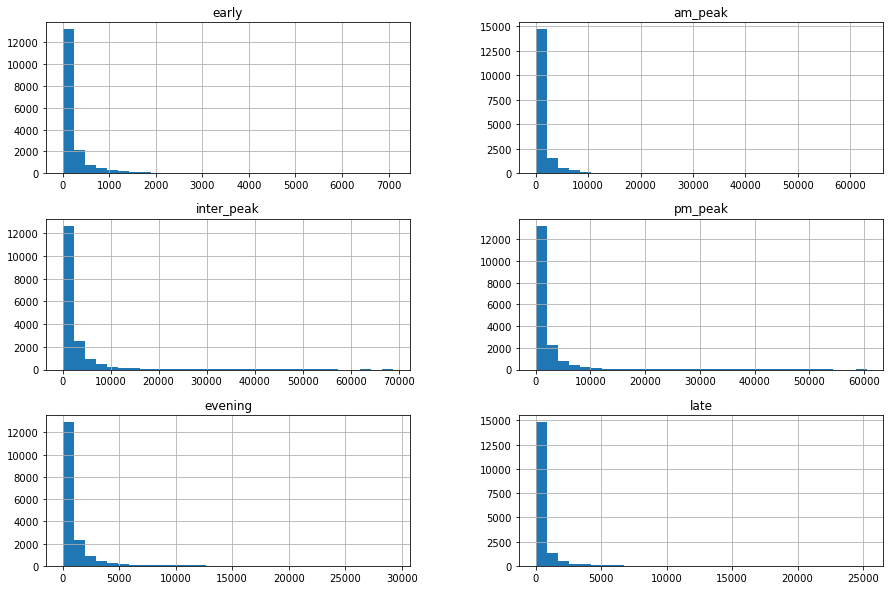

In [26]:
# Histogram View
tod_df.hist(bins=30, figsize=(15, 10)) 

<AxesSubplot:>

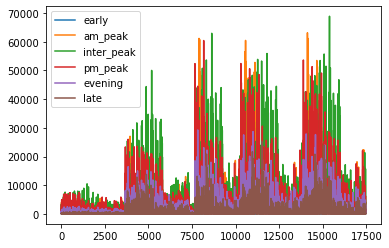

In [30]:
tod_df.plot.line() 

> ℹ️ **Objective** ℹ️
>
> Investigating the **inter_peak** and **pm_peak** column to identify entries that looks like outliers from the histogram to see if they are anomalities. 

In [4]:
# Examining the outliers from the inter_peak column 
df['station', 'inter_peak'].where(df.mode == 'LU').where(df.inter_peak > 55000).orderBy(df.station).show() 

+--------------------+----------+
|             station|inter_peak|
+--------------------+----------+
|King's Cross St. ...|   55728.0|
|       Oxford Circus|   62953.0|
|       Oxford Circus|   68897.0|
|       Oxford Circus|   55906.0|
+--------------------+----------+



In [5]:
# Examining the outliers from the pm_peak column 
df['station', 'pm_peak'].where(df.mode == 'LU').where(df.pm_peak > 55000).orderBy(df.station).show() 

+-----------+-------+
|    station|pm_peak|
+-----------+-------+
|Waterloo LU|60425.0|
+-----------+-------+





## Checking for Data Completeness

Completeness is the proportion of stored data against the potential of “100% complete". This is the degree to which the required data is in the dataset. 

Does the dataset have missing values, or if it is time-series data, does it have time period gaps? Has a bias been introduced that may change your assumptions or affect your results?

- **Measured by**: A measure of the absence of blank (null) values or the presence of non-blank values;
- **Units**: Percentage;
- **Related to**: Validity and Accuracy. 

### Missing values

> ℹ️ **Objective** ℹ️
>
> We will identify and count the number of missing values (nulls) in the dataset, include a percentage to describe the proportion of missing values per column and output the results in the following manner:
>
> `There are <number_of_missing_values> (<percentage>) null values in <column_name> column` 

In [50]:
missing_vals = {}  # Dictionary to keep track of the results 

for column in df.columns:   #Loop through each column in df 
    ncount = df.where(df[column].isNull()).count()  #Null count in column x
    tcount = df.select(df[column]).count()    #Total count of column x 
    print(f'There are {ncount} ({round(ncount/tcount*100, 2)}%) null values in {column} column') 
    missing_vals[f'{column}'] = ncount #Recording results in missing_count dictionary 

There are 0 (0.0%) null values in mode column
There are 0 (0.0%) null values in nlc column
There are 0 (0.0%) null values in asc column
There are 0 (0.0%) null values in station column
There are 32 (0.18%) null values in coverage column
There are 0 (0.0%) null values in year column
There are 0 (0.0%) null values in day column
There are 0 (0.0%) null values in dir column
There are 0 (0.0%) null values in total column
There are 0 (0.0%) null values in early column
There are 0 (0.0%) null values in am_peak column
There are 0 (0.0%) null values in inter_peak column
There are 0 (0.0%) null values in pm_peak column
There are 0 (0.0%) null values in evening column
There are 0 (0.0%) null values in late column
There are 0 (0.0%) null values in 0500-0515 column
There are 0 (0.0%) null values in 0515-0530 column
There are 0 (0.0%) null values in 0530-0545 column
There are 0 (0.0%) null values in 0545-0600 column
There are 0 (0.0%) null values in 0600-0615 column
There are 0 (0.0%) null values in

### Columns with missing values


> ℹ️ **Objective** ℹ️
>
> From the above result, we see that only the `coverage` column has null values and we will probe it to find out which modes and stations were affected. 

In [6]:
df['mode', 'station', 'coverage'].where(df.coverage.isNull()).orderBy(df.mode).show(10) 

print('Summary: ') 
df['mode', 'station', 'coverage'].where(df.coverage.isNull()).groupBy(df.mode, df.station).count().show() 

+----+--------------------+--------+
|mode|             station|coverage|
+----+--------------------+--------+
| EZL|Heathrow Terminal...|    null|
| EZL|Heathrow Terminal...|    null|
| EZL|Heathrow Terminal...|    null|
| EZL|Heathrow Terminal...|    null|
| EZL|Heathrow Terminal...|    null|
| EZL|Heathrow Terminal...|    null|
| EZL|Heathrow Terminal...|    null|
| EZL|Heathrow Terminal...|    null|
| EZL|Heathrow Terminal...|    null|
| EZL|Heathrow Terminal...|    null|
+----+--------------------+--------+
only showing top 10 rows

Summary: 
+----+--------------------+-----+
|mode|             station|count|
+----+--------------------+-----+
|  LU|Heathrow Terminal...|   16|
| EZL|Heathrow Terminal...|   16|
+----+--------------------+-----+



#### Fix Completeness 

> ℹ️ **Objective** ℹ️
>
> We have decided to completely remove entries with the missing data. 

In [7]:
# Deleting entries with null value. 
df = df.na.drop() 

# Checking to see that there are no more null values. 
print(f'Missing values in coverage column:') 
df['mode', 'station', 'coverage'].where(df.coverage.isNull()).orderBy(df.mode).show(10) 

print('Summary: ') 
df['mode', 'station', 'coverage'].where(df.coverage.isNull()).groupBy(df.mode, df.station).count().show() 

Missing values in coverage column:
+----+-------+--------+
|mode|station|coverage|
+----+-------+--------+
+----+-------+--------+

Summary: 
+----+-------+-----+
|mode|station|count|
+----+-------+-----+
+----+-------+-----+



In [20]:
# Showing summary of transport modes and stations. 

df['mode', 'station'].groupBy(df.mode, df.station).count().show(10) 

print('Station count summary:')
df['mode', 'station'].groupBy(df.mode).count().show() 

+----+--------------------+-----+
|mode|             station|count|
+----+--------------------+-----+
|  LU| Harrow & Wealdstone|   38|
|  LU|   Piccadilly Circus|   38|
|  LU|           Stratford|   38|
|  LO|           Hatch End|   38|
|  LU|        Preston Road|   38|
|  LO|Leytonstone High ...|   38|
| DLR|        Langdon Park|   38|
| EZL|              Ilford|   16|
|  LU|Elephant & Castle LU|   38|
|  LU|                Oval|   38|
+----+--------------------+-----+
only showing top 10 rows

Station count summary:
+-------+-----+
|   mode|count|
+-------+-----+
|    EZL|  512|
|     LO| 4256|
|    DLR| 1710|
|    TRM|  312|
|     LU|10184|
|TfLRail|  452|
+-------+-----+



In [55]:
# A final check before saving 
df.show(1) 
df.printSchema()

+----+---+----+----------+--------------------+----------+---+---+------+-----+-------+----------+-------+-------+----+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+-

### Save Updates 

With the data quality checks completed, we will now save the result to a CSV file.  

In [56]:
pd_df = df.toPandas() 

In [57]:
pd_df.to_csv('../Data/cleaned_historical_tube_data.csv', index=0) 